## Introduction


Airbnb is now one of the most popular ways to select when you want to choose an accomodation for you leisure trip or business trip. In this analysis, I will explore the Boston Airbnb dataset to gain insights into the home-sharing market in this city. I will analyze the various aspects such as vibe, price, reviews, amenities, and more. By understanding these factors, I aim to help both hosts and guests make informed decisions about their properties and stays in Boston. Here are some business question that I try to explore in this bog: <br>
1. Discribe the most vibe in Boston Airbnb? <br>
2. What is the average price of a listing in each neighborhood of Boston? <br>
3. Which neighborhoods in Boston that are more popular amongst guests? <br>
4. Which month of the year that have higher demand for Airbnb listings in Boston? <br>
5. Which month is airbnb in boston the most expensive? <br>
6. Are there particular amenities or features that tend to have a greater impact on the listing price in Boston? <br>
7. What are the most common keywords used in the reviews of listings in Boston?

## Import library and Load data

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython import display
import warnings
import nltk
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
from wordcloud import WordCloud, STOPWORDS
from sklearn.ensemble import RandomForestRegressor

stop_words = set(stopwords.words("english"))

%matplotlib inline

In [7]:
# Load Data
listings_df = pd.read_csv("listings.csv")
calendar_df = pd.read_csv("calendar.csv")
reviews_df = pd.read_csv("reviews.csv")

## Define Functions

In [8]:
# Remove columns with entire missing and constant columns
def remove_useless_column(df):
    # Create list of column's names having entire missing value
    list_entire_null = list(df.columns[df.isna().mean() == 1])
    # Create list of column's names having constant value
    list_constant_col = set(df.columns[df.nunique() <= 1])
    print("The number of comlumns with entire null is {}".format(len(list_entire_null)))
    print("The number of constant comlumns is {}".format(len(list_constant_col)))
    df_drop = df.copy()
    if len(list_entire_null) != 0:
        df_drop = df.drop(columns = list_entire_null) # drop columns with entire missing value (if yes)
    if len(list_constant_col) != 0:
        for col in list_constant_col:
            try:
                df_drop = df_drop.drop(columns = col) ## drop columns with constant value (if yes)
            except:
                continue
    return df_drop

In [9]:
# Change the currency with format "$0,000.00" to float
def currency_to_float(row):
    try:
        if '$' in row:
            row = row.replace('$', '')
        if ',' in row:
            row = row.replace(',', '')
        row = float(str(row))
        return row
    except:
        return row

## Data Processing

### Calendar

In [10]:
print("Calendar: {0} rows - {1} columns".format(calendar_df.shape[0], calendar_df.shape[1]))

Calendar: 1308890 rows - 4 columns


In [11]:
# View the sample
calendar_df.head(3)

,listing_id,date,available,price
0,12147973,2017-09-05,f,NaN
1,12147973,2017-09-04,f,NaN
2,12147973,2017-09-03,f,NaN


In [12]:
# Have a overview look at calendar data
calendar_df.describe(include='object')

,date,available,price
count,1308890,1308890,643037
unique,365,2,1246
top,2017-09-05,f,$150.00
freq,3586,665853,20752


In [14]:
#Change date column to date format
calendar_df['date'] = pd.to_datetime(calendar_df['date'])
# Remove useless columns in calendar table
calendar_df = remove_useless_column(calendar_df)
# Drop duplicate
calendar_df.drop_duplicates()

calendar_df['price'] = calendar_df['price'].apply(lambda x: currency_to_float(x))

The number of comlumns with entire null is 0
The number of constant comlumns is 0


In [19]:
# Create new year and month columns for more use
calendar_df['month'] = calendar_df['date'].dt.month
calendar_df['year'] = calendar_df['date'].dt.year
calendar_df.head()

,listing_id,date,available,price,month,year
0,12147973,2017-09-05,f,NaN,9,2017
1,12147973,2017-09-04,f,NaN,9,2017
2,12147973,2017-09-03,f,NaN,9,2017
3,12147973,2017-09-02,f,NaN,9,2017
4,12147973,2017-09-01,f,NaN,9,2017


In [23]:
print("oldest date is {0} and latest date is {1}".format(calendar_df['date'].min(),calendar_df['date'].max()))

oldest date is 2016-09-06 00:00:00 and latest date is 2017-09-05 00:00:00


### Listing

In [24]:
print("Listings: {0} rows - {1} columns".format(listings_df.shape[0], listings_df.shape[1]))

Listings: 3585 rows - 95 columns


In [25]:
listings_df.head(3)

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,12147973,https://www.airbnb.com/rooms/12147973,20160906204935,2016-09-07,Sunny Bungalow in the City,"Cozy, sunny, family home. Master bedroom high...",The house has an open and cozy feel at the sam...,"Cozy, sunny, family home. Master bedroom high...",none,"Roslindale is quiet, convenient and friendly. ...",...,NaN,f,NaN,NaN,f,moderate,f,f,1,NaN
1,3075044,https://www.airbnb.com/rooms/3075044,20160906204935,2016-09-07,Charming room in pet friendly apt,Charming and quiet room in a second floor 1910...,Small but cozy and quite room with a full size...,Charming and quiet room in a second floor 1910...,none,"The room is in Roslindale, a diverse and prima...",...,9.0,f,NaN,NaN,t,moderate,f,f,1,1.30
2,6976,https://www.airbnb.com/rooms/6976,20160906204935,2016-09-07,Mexican Folk Art Haven in Boston,"Come stay with a friendly, middle-aged guy in ...","Come stay with a friendly, middle-aged guy in ...","Come stay with a friendly, middle-aged guy in ...",none,The LOCATION: Roslindale is a safe and diverse...,...,10.0,f,NaN,NaN,f,moderate,t,f,1,0.47


In [26]:
listings_df.describe(include='object')

,listing_url,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,...,extra_people,calendar_updated,calendar_last_scraped,first_review,last_review,requires_license,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification
count,3585,3585,3585,3442,2528,3585,3585,2170,1610,2295,...,3585,3585,3585,2829,2829,3585,3585,3585,3585,3585
unique,3585,1,3504,3113,2268,3423,1,1728,1269,1859,...,51,38,1,975,404,1,2,4,2,2
top,https://www.airbnb.com/rooms/12147973,2016-09-07,Lux 2BR by Fenway w/WiFi,"The unit is stylishly designed for comfort, va...",The studio's kitchenette comes equipped with a...,"The unit is stylishly designed for comfort, va...",none,Conveniently bordering the neighborhoods of th...,Although we do not allow pets in our apartment...,"These newly constructed, luxury apartments epi...",...,$0.00,today,2016-09-06,2016-04-05,2016-09-05,f,f,strict,f,f
freq,1,3585,8,21,17,7,3585,21,44,26,...,2211,833,3585,23,118,3585,2991,1582,3518,3348


In [27]:
listings_df = remove_useless_column(listings_df)
listings_df = listings_df.drop_duplicates()
listings_df['price'] = listings_df['price'].apply(lambda x: currency_to_float(x))
listings_df['price'].astype(float)
listings_df['extra_people'] = listings_df['extra_people'].apply(lambda x: currency_to_float(x))
listings_df['extra_people'].astype(float)

The number of comlumns with entire null is 4
The number of constant comlumns is 12


0        0.0
1        0.0
2       20.0
3       25.0
4        0.0
        ... 
3580    24.0
3581     0.0
3582     0.0
3583    30.0
3584    30.0
Name: extra_people, Length: 3585, dtype: float64

### Review

In [28]:
print("Reviews: {0} rows - {1} columns".format(reviews_df.shape[0], reviews_df.shape[1]))

Reviews: 68275 rows - 6 columns


In [29]:
reviews_df.head(3)

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,1178162,4724140,2013-05-21,4298113,Olivier,My stay at islam's place was really cool! Good...
1,1178162,4869189,2013-05-29,6452964,Charlotte,Great location for both airport and city - gre...
2,1178162,5003196,2013-06-06,6449554,Sebastian,We really enjoyed our stay at Islams house. Fr...


In [30]:
reviews_df.describe(include='object')

,date,reviewer_name,comments
count,68275,68275,68222
unique,2045,14775,67311
top,2016-04-19,David,The host canceled this reservation the day bef...
freq,342,654,112


In [31]:
reviews_df.describe()

,listing_id,id,reviewer_id
count,6.827500e+04,6.827500e+04,6.827500e+04
mean,4.759910e+06,5.246516e+07,2.802389e+07
std,3.788990e+06,2.790991e+07,2.234097e+07
min,3.353000e+03,1.021000e+03,1.430000e+02
25%,1.458081e+06,3.010420e+07,9.001346e+06
50%,4.080000e+06,5.223121e+07,2.305179e+07
75%,7.377034e+06,7.663248e+07,4.213454e+07
max,1.484378e+07,9.999045e+07,9.335034e+07


In [32]:
reviews_df = remove_useless_column(reviews_df)
reviews_df = reviews_df.drop_duplicates()

The number of comlumns with entire null is 0
The number of constant comlumns is 0


## Insights from data

### 1. Discribe the most vibe in Boston Airbnb?

C:\Users\BLan\AppData\Local\Temp\ipykernel_20972\3637149489.py:9: FutureWarning: The default value of regex will change from True to False in a future version.
  selected_listings.loc[:, 'neighborhood_overview'] = selected_listings.loc[:, 'neighborhood_overview'].str.lower().str.replace('[^a-zA-Z0-9\s]', '')


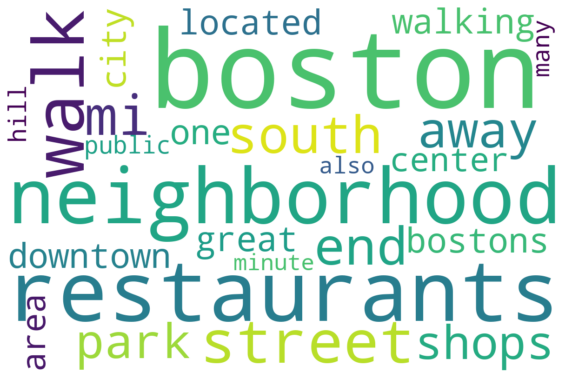

In [33]:
selected_feature = ['neighborhood_overview', 'access', 'neighbourhood', 'neighbourhood_cleansed', 'property_type',
            'room_type', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'bed_type', 'amenities', 'square_feet',
            'price', 'cleaning_fee', 'guests_included', 'extra_people', 'reviews_per_month']

selected_listings = listings_df[selected_feature]
selected_listings = selected_listings.dropna(subset=['neighborhood_overview'])
# Preprocess review text
selected_listings.loc[:, 'neighborhood_overview'] = selected_listings.loc[:, 'neighborhood_overview'].astype(str)
selected_listings.loc[:, 'neighborhood_overview'] = selected_listings.loc[:, 'neighborhood_overview'].str.lower().str.replace('[^a-zA-Z0-9\s]', '')
selected_listings['tokenized_neighborhood_overview'] = selected_listings['neighborhood_overview'].apply(word_tokenize)
selected_listings['filter_neighborhood_overview'] = selected_listings['tokenized_neighborhood_overview'].apply(lambda x: [word for word in x if word not in stop_words])



# Count word frequency
word_counts = {}
for overview in selected_listings['filter_neighborhood_overview']:
    for word in overview:
        if word in word_counts:
            word_counts[word] += 1
        else:
            word_counts[word] = 1

# Create wordcloud
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    wordcloud = WordCloud(stopwords=STOPWORDS, background_color='white', max_words=25, width=1200, height=800).generate_from_frequencies(word_counts)

# Visualize word cloud
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

The popularity of a neighborhood in Boston is determined by the presence of restaurants, shops, parks, and its central location.

### 2. What is the average price of a listing in each neighborhood of Boston?

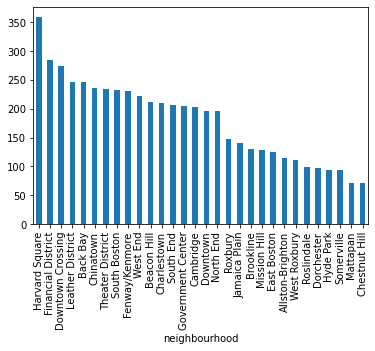

In [34]:
mean_price_neighbour = listings_df.groupby(['neighbourhood'])['price'].mean().sort_values(ascending=False).plot.bar()

The average price of Airbnb listings varies greatly across neighborhoods in Boston, with Harvard Square being the most expensive and Chestnut Hill being the cheapest.

### 3. Which neighborhoods in Boston that are more popular amongst guests?

<AxesSubplot:>

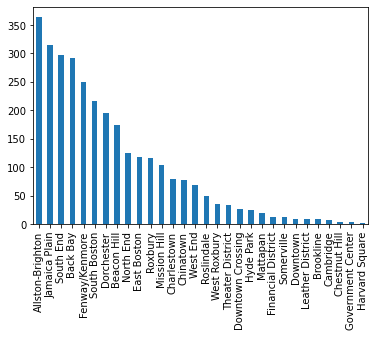

In [36]:
listings_df['neighbourhood'].value_counts().plot.bar()

Alston-Brington, Jamaica Pain, and South End are the neighborhoods with the highest number of Airbnb listings, while Chestnut Hill and Harvard Square have the lowest number.

<AxesSubplot:xlabel='neighbourhood'>

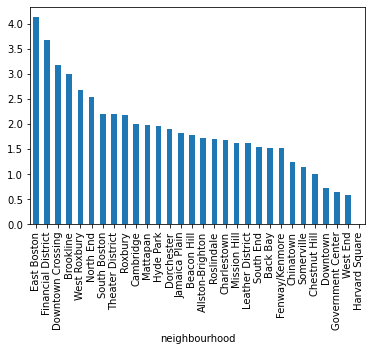

In [37]:
listings_df.groupby(['neighbourhood'])['reviews_per_month'].mean().sort_values(ascending=False).plot.bar()

Visitor reviews are concentrated in specific neighborhoods, with East Boston, Financial District, and Downtown Crossing having more reviews per month than other neighborhoods. Although they dont have many airbnb listings like many of other neighborhoods.

In [38]:
listing_review = listings_df.merge(reviews_df, how = 'left', left_on = 'id' , right_on = 'listing_id')
listing_review.head(3)

,id_x,listing_url,name,summary,space,description,neighborhood_overview,notes,transit,access,...,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month,listing_id,id_y,date,reviewer_id,reviewer_name,comments
0,12147973,https://www.airbnb.com/rooms/12147973,Sunny Bungalow in the City,"Cozy, sunny, family home. Master bedroom high...",The house has an open and cozy feel at the sam...,"Cozy, sunny, family home. Master bedroom high...","Roslindale is quiet, convenient and friendly. ...",NaN,"The bus stop is 2 blocks away, and frequent. B...","You will have access to 2 bedrooms, a living r...",...,f,f,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3075044,https://www.airbnb.com/rooms/3075044,Charming room in pet friendly apt,Charming and quiet room in a second floor 1910...,Small but cozy and quite room with a full size...,Charming and quiet room in a second floor 1910...,"The room is in Roslindale, a diverse and prima...","If you don't have a US cell phone, you can tex...",Plenty of safe street parking. Bus stops a few...,Apt has one more bedroom (which I use) and lar...,...,f,f,1,1.3,3075044.0,13631717.0,2014-06-01,9645972.0,Dmitrii,Andrea is a great host. Neighborhood is wonder...
2,3075044,https://www.airbnb.com/rooms/3075044,Charming room in pet friendly apt,Charming and quiet room in a second floor 1910...,Small but cozy and quite room with a full size...,Charming and quiet room in a second floor 1910...,"The room is in Roslindale, a diverse and prima...","If you don't have a US cell phone, you can tex...",Plenty of safe street parking. Bus stops a few...,Apt has one more bedroom (which I use) and lar...,...,f,f,1,1.3,3075044.0,13866662.0,2014-06-06,12020681.0,Paola,We had a great time at Andrea's place. He is v...


<AxesSubplot:xlabel='neighbourhood'>

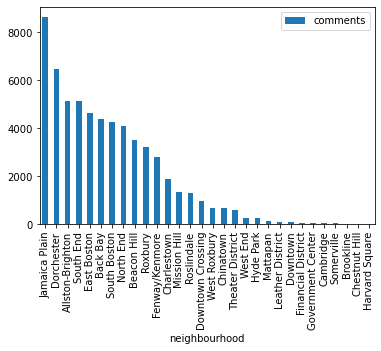

In [39]:
pd.DataFrame(listing_review.groupby('neighbourhood')['comments'].count().sort_values(ascending=False)).plot.bar()

When it comes to the high number of reviews for Jamaica Plain, the relatively low number of reviews per month might suggest that visitors come here mostly during the tourist season.

### 4. Which month of the year that have higher demand for Airbnb listings in Boston?

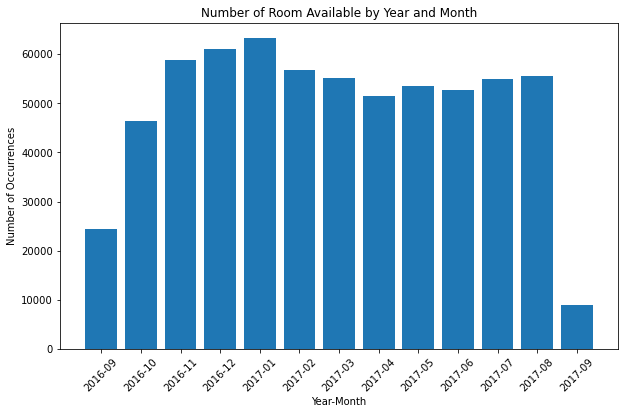

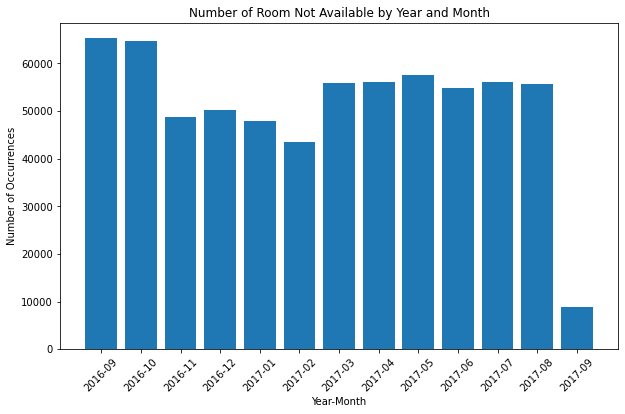

In [43]:
# Group by year, month, and availability and count occurrences
availability_counts = (calendar_df.groupby(['year', 'month', 'available'])['listing_id']
                       .count()
                       .reset_index(name='count'))
# Filter data by availability
availability_t = availability_counts[availability_counts['available'] == 't']
availability_f = availability_counts[availability_counts['available'] == 'f']

# Convert index to string of month-year format
availability_t.index = pd.to_datetime({'year': availability_t['year'],
                                        'month': availability_t['month'],
                                        'day': 1})
availability_t.index = availability_t.index.strftime('%Y-%m')

availability_f.index = pd.to_datetime({'year': availability_f['year'],
                                        'month': availability_f['month'],
                                        'day': 1})
availability_f.index = availability_f.index.strftime('%Y-%m')

# Create "t" chart
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(availability_t.index, availability_t['count'])
ax.set(title='Number of Room Available by Year and Month', xlabel='Year-Month', ylabel='Number of Occurrences')
plt.xticks(rotation=45)
plt.show()

# Create "f" chart
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(availability_f.index, availability_f['count'])
ax.set(title='Number of Room Not Available by Year and Month', xlabel='Year-Month', ylabel='Number of Occurrences')
plt.xticks(rotation=45)
plt.show()

### 5. Which month is airbnb in boston the most expensive?

C:\Users\BLan\AppData\Local\Temp\ipykernel_20972\2914694089.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  calendar_df_notna['date'] = pd.to_datetime(calendar_df_notna['date'])
C:\Users\BLan\AppData\Local\Temp\ipykernel_20972\2914694089.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  calendar_df_notna['month'] = calendar_df_notna['date'].dt.month
C:\Users\BLan\AppData\Local\Temp\ipykernel_20972\2914694089.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFra

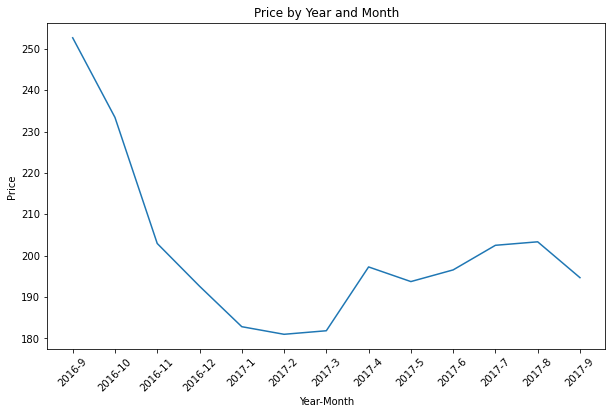

In [44]:
# Convert date column to datetime type
calendar_df_notna = calendar_df[calendar_df['price'].notna()]
calendar_df_notna['date'] = pd.to_datetime(calendar_df_notna['date'])

# Add month and year columns
calendar_df_notna['month'] = calendar_df_notna['date'].dt.month
calendar_df_notna['year'] = calendar_df_notna['date'].dt.year

# Group by year and month and calculate mean price
price_by_year_month = calendar_df_notna.groupby(['year', 'month'])['price'].mean()

# Convert price_by_year_month to DataFrame
price_by_year_month_df = price_by_year_month.reset_index()

# Plot price by year and month
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(price_by_year_month_df['year'].astype(str) + '-' + price_by_year_month_df['month'].astype(str), price_by_year_month_df['price'])
ax.set(xlabel='Year-Month', ylabel='Price', title='Price by Year and Month')
plt.xticks(rotation=45)
plt.show()

Bookings are most concentrated during September and October 2016, and the price increases sharply during those times.

### 6. Are there particular amenities or features that tend to have a greater impact on the listing price in Boston?

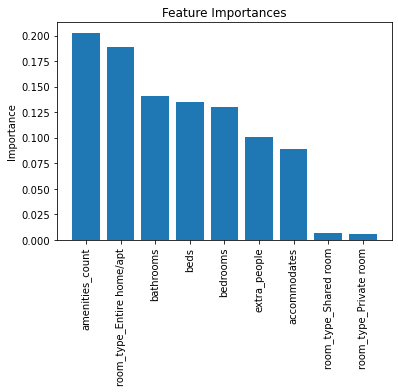

In [45]:
# Select relevant features
selected_features = ['accommodates', 'bathrooms', 'bedrooms', 'beds', 'room_type', 'amenities', 'extra_people', 'price']

# Remove redundant or uninformative features
listings_df_1 = listings_df[selected_features]

# Process categorical variables (e.g., room_type)
listings_df_1 = pd.get_dummies(listings_df_1, columns=['room_type'])

# Process amenities by counting the number of amenities per listing
listings_df_1['amenities_count'] = listings_df_1['amenities'].apply(lambda x: len(x.split(',')))

# Remove original amenities column
listings_df_1 = listings_df_1.drop('amenities', axis=1)

listings_df_1 = listings_df_1[listings_df_1['price'].notna()]

# Fill missing values with mean
listings_df_1 = listings_df_1.fillna(listings_df_1.mean())

# Split the data into training and test sets
train_size = int(len(listings_df_1) * 0.8)
train_df = listings_df_1[:train_size]
test_df = listings_df_1[train_size:]

# Set X and y variables for training and test sets
X_train = train_df.drop('price', axis=1)
y_train = train_df['price']
X_test = test_df.drop('price', axis=1)
y_test = test_df['price']

# Fit Random Forest Regression model
model = RandomForestRegressor()
model.fit(X_train, y_train)

# Sort feature importances in descending order
feature_importances = pd.Series(model.feature_importances_, index=X_train.columns).sort_values(ascending=False)

# Plot feature importances as bar chart
plt.bar(feature_importances.index, feature_importances.values)
plt.xticks(rotation='vertical')
plt.ylabel('Importance')
plt.title('Feature Importances')
plt.show()

The room type as entire home/apt and number of amenities most affect to the price of the airbnb.

### 7. What are the most common keywords used in the reviews of listings in Boston?

C:\Users\BLan\AppData\Local\Temp\ipykernel_20972\3203895188.py:6: FutureWarning: The default value of regex will change from True to False in a future version.
  reviews_listings['comments'] = reviews_listings['comments'].str.lower().str.replace('[^a-zA-Z0-9\s]', '')


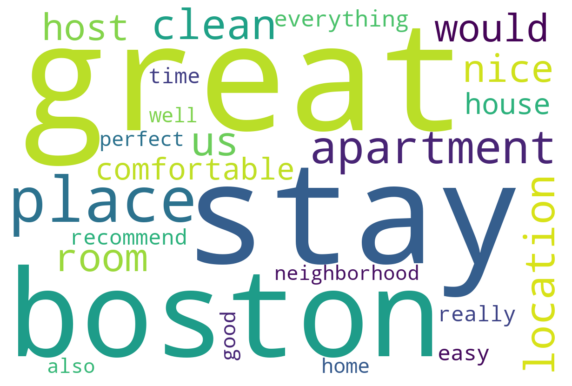

In [46]:
# Join listings and reviews data
reviews_listings = pd.merge(reviews_df, listings_df, left_on='listing_id', right_on='id')

# Preprocess review text
reviews_listings['comments'] = reviews_listings['comments'].astype(str)
reviews_listings['comments'] = reviews_listings['comments'].str.lower().str.replace('[^a-zA-Z0-9\s]', '')
 
reviews_listings['tokenized_comments'] = reviews_listings['comments'].apply(lambda x: word_tokenize(x))
reviews_listings['filtered_comments'] = reviews_listings['tokenized_comments'].apply(lambda x: [word for word in x if word not in stop_words])

# Count word frequency
word_counts = {}
for comment in reviews_listings['filtered_comments']:
    for word in comment:
        if word in word_counts:
            word_counts[word] += 1
        else:
            word_counts[word] = 1

# Generate word cloud
wordcloud = WordCloud(stopwords=STOPWORDS, background_color='white', max_words=25, width=1200, height=800).generate_from_frequencies(word_counts)

# Visualize word cloud
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()


Most guests mentioned great location, nice host, cleanliness, comfort, and ease of use in their reviews.

## Conclusion

Overall, this analysis provides valuable insights into the Boston Airbnb market. We have learned that the most popular areas in Boston are those with good central locations, restaurants, shops, and parks. We have also discovered that different neighborhoods have different average prices for Airbnb listings, with Harvard Square being the most expensive and Chestnut Hill being the cheapest.

Furthermore, we have found that different neighborhoods have different numbers of listings and reviews, with Alston-Brington, Jamaica Plain, and South End having the most listings and East Boston, Financial District, and Downtown Crossing having the most reviews. We also noticed that Jamaica Plain has many reviews, but few reviews per month, indicating that visitors may come during the tourist season.

In addition, the booking trends over time showed that September and October 2016 were the most popular months for bookings, and the price increased sharply during that period. Finally, guests often mention location, cleanliness, comfort, and the quality of the host in their reviews, indicating that these are the most important factors to consider when choosing an Airbnb listing in Boston.

Overall, this analysis can be useful for both hosts and guests in Boston, as it provides insights about the neighborhoods that are most popular, the pricing trends, and the factors that are most important to guests when booking an Airbnb property in the city. These insights can help hosts make informed decisions about pricing and amenities, while also helping guests choose the best neighborhood and property that meets their needs and preferences.